In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# Check extracted data structure
dataset_dir = '/content/drive/MyDrive/Leaf_coffe_dataset'
classes = os.listdir(dataset_dir)

print("Classes:", classes)
for cls in classes:
    class_path = os.path.join(dataset_dir, cls)
    print(f"Class '{cls}' contains {len(os.listdir(class_path))} images.")

Classes: ['Leaf rust', 'Phoma', 'Cerscospora', 'Healthy', 'Miner']
Class 'Leaf rust' contains 8336 images.
Class 'Phoma' contains 6571 images.
Class 'Cerscospora' contains 7681 images.
Class 'Healthy' contains 18983 images.
Class 'Miner' contains 16364 images.


Class: Leaf rust


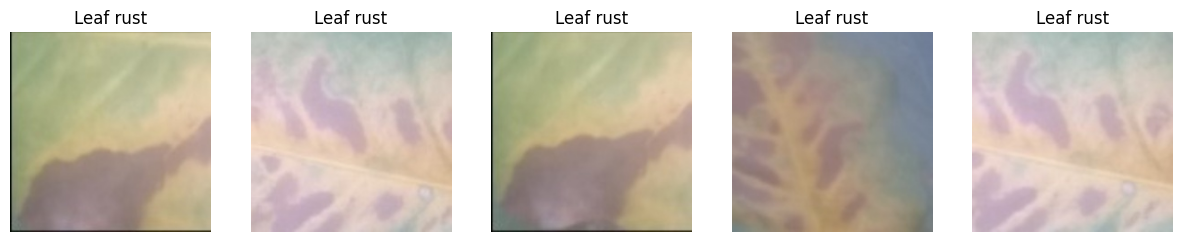

Class: Phoma


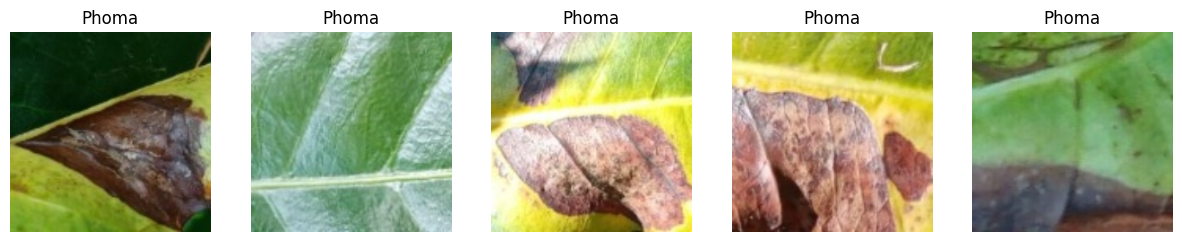

Class: Cerscospora


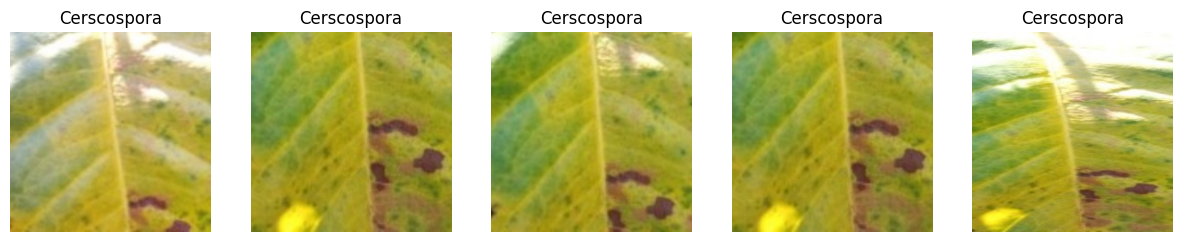

Class: Healthy


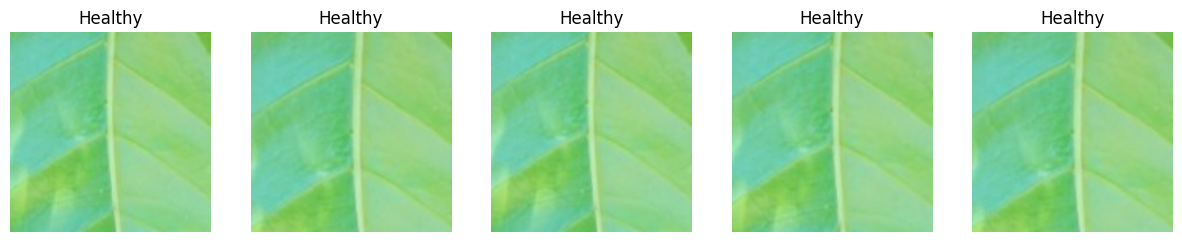

Class: Miner


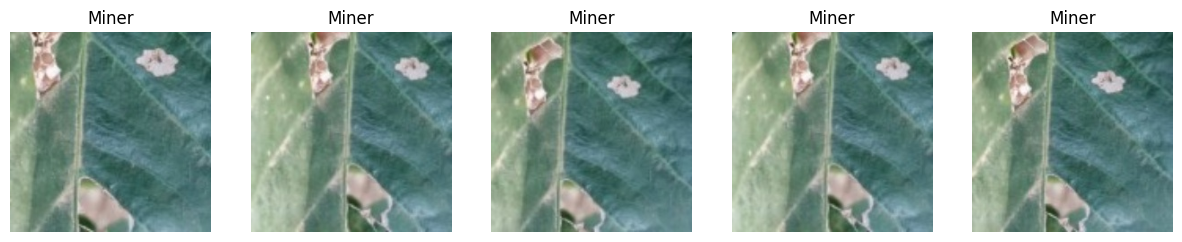

In [ ]:
for cls in classes:
    class_path = os.path.join(dataset_dir_agumentation, cls)
    sample_images = os.listdir(class_path)[:5]  # Take 5 sample images
    print(f"Class: {cls}")
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(class_path, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
    plt.show()



In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
import random

# Paths
input_dir = "/content/drive/MyDrive/Leaf_coffe_dataset"  # Original dataset
output_dir = "/content/drive/MyDrive/Leaf_coffe_augmented"  # Augmented dataset
os.makedirs(output_dir, exist_ok=True)

# Target number of images per class
TARGET_IMAGES = 30000

# Augmentation functions
def augment_brightness(image):
    return tf.image.random_brightness(image, max_delta=0.05)  # Reduce brightness range

def augment_contrast(image):
    return tf.image.random_contrast(image, lower=0.97, upper=1.03)  # Subtle contrast change

def augment_flip(image):
    return tf.image.flip_left_right(image)

def augment_rotate(image):
    """Rotate image by a small random angle."""
    h, w, _ = image.shape
    angle = np.random.uniform(-15, 15)  # Smaller rotation range
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)

def augment_shift(image):
    """Apply small translation shift."""
    h, w, _ = image.shape
    w_shift = np.random.uniform(-0.1, 0.1) * w  # Reduced shift range
    h_shift = np.random.uniform(-0.1, 0.1) * h
    M_shift = np.float32([[1, 0, w_shift], [0, 1, h_shift]])
    return cv2.warpAffine(image, M_shift, (w, h), borderMode=cv2.BORDER_REFLECT_101)

def augment_zoom(image):
    """Apply slight zoom in or out."""
    zoom_factor = np.random.uniform(0.9, 1.1)  # Reduce zoom range
    new_size = int(224 * zoom_factor)
    image = cv2.resize(image, (new_size, new_size))
    return cv2.resize(image, (224, 224))

def augment_cover_part(image):
    """Randomly covers a part of the image with a black square."""
    h, w, _ = image.shape
    mask_size = random.randint(int(h * 0.1), int(h * 0.25))  # Random mask size (10%-25% of image)

    x = random.randint(0, w - mask_size)
    y = random.randint(0, h - mask_size)

    image[y:y+mask_size, x:x+mask_size, :] = 0  # Black patch
    return image

# Augmentation techniques
AUGMENTATIONS = [
    augment_brightness, augment_contrast, augment_flip,
    augment_rotate, augment_shift, augment_zoom, augment_cover_part
]

# Process each class
for class_name in os.listdir(input_dir):
    class_input_path = os.path.join(input_dir, class_name)
    class_output_path = os.path.join(output_dir, class_name)
    os.makedirs(class_output_path, exist_ok=True)

    print(f"Processing class '{class_name}'...")

    # Read images
    images = os.listdir(class_input_path)
    num_original = len(images)

    if num_original == 0:
        print(f"⚠️ Skipping '{class_name}' (no images found).")
        continue

    print(f"🔹 Found {num_original} original images.")

    # Copy original images
    for image_name in images:
        image_path = os.path.join(class_input_path, image_name)
        image = cv2.imread(image_path)
        if image is None:
            continue  # Skip broken images
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image = cv2.resize(image, (224, 224))  # Resize

        # Save original image
        save_path = os.path.join(class_output_path, f"orig_{image_name}")
        cv2.imwrite(save_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

    # Calculate how many augmented images are needed
    num_needed = TARGET_IMAGES - num_original
    print(f"🔹 Generating {num_needed} augmented images.")

    # Augment images
    aug_count = 0
    while aug_count < num_needed:
        for image_name in images:
            image_path = os.path.join(class_input_path, image_name)
            image = cv2.imread(image_path)
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))

            # Select 1 to 3 random augmentations
            num_augmentations = random.randint(1, 3)
            chosen_augmentations = random.sample(AUGMENTATIONS, num_augmentations)

            # Apply augmentations
            aug_image = image.astype(np.float32) / 255.0  # Normalize
            for aug_func in chosen_augmentations:
                if aug_func in [augment_brightness, augment_contrast, augment_flip]:
                    aug_image = tf.convert_to_tensor(aug_image, dtype=tf.float32)
                    aug_image = aug_func(aug_image)
                    aug_image = tf.image.convert_image_dtype(aug_image, tf.uint8).numpy()
                else:
                    aug_image = (aug_func(aug_image * 255)).astype(np.uint8) / 255.0  # Convert safely

            aug_image = (aug_image * 255).astype(np.uint8)  # Convert back to 0-255

            save_path = os.path.join(class_output_path, f"aug_{aug_count}_{image_name}")
            cv2.imwrite(save_path, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))

            aug_count += 1
            if aug_count >= num_needed:
                break  # Stop when we reach 30,000

    print(f"✅ Class '{class_name}' now contains 30,000 images.")

print("🎉 Data augmentation complete!")




Processing class 'Leaf rust'...
🔹 Found 8336 original images.
🔹 Generating 21664 augmented images.
✅ Class 'Leaf rust' now contains 30,000 images.
Processing class 'Phoma'...
🔹 Found 6571 original images.
🔹 Generating 23429 augmented images.
✅ Class 'Phoma' now contains 30,000 images.
Processing class 'Cerscospora'...
🔹 Found 7681 original images.
🔹 Generating 22319 augmented images.
✅ Class 'Cerscospora' now contains 30,000 images.
Processing class 'Healthy'...
🔹 Found 18983 original images.
🔹 Generating 11017 augmented images.
✅ Class 'Healthy' now contains 30,000 images.
Processing class 'Miner'...
🔹 Found 16339 original images.
🔹 Generating 13661 augmented images.
✅ Class 'Miner' now contains 30,000 images.
🎉 Data augmentation complete!


In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to augmented dataset
dataset_dir_augmented = "/content/drive/MyDrive/Leaf_coffe_augmented"

# Get class names
classes = os.listdir(dataset_dir_augmented)

for cls in classes:
    class_path = os.path.join(dataset_dir_augmented, cls)

    # Ensure the class folder contains images and filter only augmented images
    sample_images = [img for img in os.listdir(class_path) if img.startswith('aug_') and img.endswith(('.png', '.jpg', '.jpeg'))][:5]

    if not sample_images:
        print(f"⚠️ No augmented images found for class: {cls}")
        continue

    print(f"📂 Class: {cls} (Augmented Samples)")
    plt.figure(figsize=(15, 5))

    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(class_path, img_name)
        img = mpimg.imread(img_path)  # Read image
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')

    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Leaf_coffe_augmented'